### License

Copyright 2021 Patrick Hall (jphall@gwu.edu), Melis Diken(midiken@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

DISCLAIMER: This notebook is not legal or compliance advice.

## Assignment 3

In [1]:
import datetime                                               # for timestamp 
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python
from sklearn.metrics import accuracy_score, f1_score          # for selecting model cutoffs
import random
# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

 

### Define utility functions

#### Utility function to calculate confusion matrices by demographic group

In [2]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        :param verbose: Whether to print confusion matrix titles, default True. 
        :return: Confusion matrix as pandas dataframe. 
        
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True) 

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))
    
    return cm_frame

#### Utility function to calculate AIR

In [3]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices. 
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True. 
        :return: AIR.
        
    """

    eps = 1e-20 # numeric stability and divide by 0 protection
    
    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return ((protected_prop + eps)/(reference_prop + eps))


#### Utility function to select probability cutoff by F1

In [4]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None): 
    
    """ Utility function for finding max. F1. 
        Coupled to get_confusion_matrix() and air(). 
        Assumes 1 is the marker for class membership.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.
    
    """
    
    do_air = all(v is not None for v in [air_reference, air_protected])
    
    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])
    
    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)
    
    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR  
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=False)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            
        f1_frame = f1_frame.append(row_dict, ignore_index=True)
            
    del temp_df
        
    return f1_frame    

#### Define utility function for random grid search

In [5]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None, 
             air_reference=None, air_protected=None, air_cut=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """
    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected, air_cut])
    if do_air: 
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    mxgb_grid_frame = pd.DataFrame(columns=columns)
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
            
        # conditionally select random features 
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
            

        
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)   
        
 
        # compose values to add to xgb_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate.best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR  
            valid_phat = valid.copy(deep=True)
            dvalid= xgb.DMatrix(valid[x_names], valid[y_name])
            valid_phat['phat'] = candidate.predict(dvalid)
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=False)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            del valid_phat

        # append run to xgb_grid_frame
        mxgb_grid_frame = mxgb_grid_frame.append(row_dict, ignore_index=True)

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_score = candidate.best_score
            best_mxgb = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
        
        del row_dict

    return best_mxgb, mxgb_grid_frame

#### Start global timer

In [6]:
tic = time.time()

#### Import data

In [7]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

#### Assign basic modeling roles

In [8]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

### Fit interpretable models

#### Split data into train and validation partitions

In [9]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Monotonic XGBoost

#### Fit monotonic XGBoost with random grid search

In [10]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
m=  ['term_360', 'conforming',  'income_std'] #82.70
mo=  ['term_360']#82.72
ml = ['term_360', 'conforming', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'income_std', 'debt_to_income_ratio_std']#82.33
"""
    Looking at the local feature importance of 'term_360' and 'comforming', these features are the only features that 
    positively contribute to the model across all three percentiles. However term_360'has a greater global importance 
    therefore enforcing a monotonicity constraints could make a difference in the model 

"""

mono_constraints = tuple([int(i) for i in np.sign(train[mo + [y_name]].corr(method='spearman')[y_name].values[:-1])])
# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search
best_mxgb,mxgb_grid_frame =xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))


Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/50: 0.8203.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1,)}
Grid search new best score discovered at iteration 2/50: 0.8256.
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic'

---------- ----------
Grid search run 22/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.4, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 23/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 24/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.

---------- ----------
Grid search run 43/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 44/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 45/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.

#### Basic AUC assessment

In [11]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.8272.


#### Score validation data with model

In [12]:
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dvalid, iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat']) 
best_mxgb_phat = pd.concat([valid.reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.184347
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.309283
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.020942
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.012035
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.005424


### Investigate Best Model for Discrimination

#### Find optimal cutoff based on 

Cutoffs are normally selected by maximizing a quality statistic or a business metric, and not by considering bias and discrimination.

In [13]:
f1_frame = get_max_f1_frame(best_mxgb_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best XGB F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.233445  0.383217
2    0.02  0.263938  0.482437
3    0.03  0.283181  0.536009
4    0.04  0.298514  0.574046
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best XGB F1: 0.3685 achieved at cutoff: 0.18 with accuracy: 0.7886.


##### Find confusion matrices for demographic groups

In [14]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_mxgb_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       484       949
predicted: 0       180      1579

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        98       190
predicted: 0        50      2912

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      2014      6295
predicted: 0      1151     25065

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1062      3204
predicted: 0       602     10964

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       868      2242
predicted: 0       372      6550



#### Find AIR for Asian people

In [15]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.759
Asian proportion accepted: 0.911
Adverse impact ratio for Asian people vs. White people: 1.200


#### Find AIR for Black people

In [16]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.759
Black proportion accepted: 0.551
Adverse impact ratio for Black people vs. White people: 0.726


#### Find AIR for Females

In [17]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.731
Female proportion accepted: 0.690
Adverse impact ratio for Females vs. Males: 0.944


### Attempt remediation of discovered discrimination

#### Simplest remediation: Find cutoff with better Black vs. White AIR

In [18]:
f1_frame = get_max_f1_frame(best_mxgb_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()


,cut,f1,acc,air
22,0.22,0.362007,0.832651,0.816971
23,0.23,0.353293,0.842550,0.839034
24,0.24,0.342683,0.851846,0.862130
25,0.25,0.328598,0.859436,0.877861
26,0.26,0.315052,0.867797,0.892859


#### Check that other groups are not adversely impacted by change

In [19]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_mxgb_phat, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.129
Adverse impact ratio for Black people vs. White people: 0.817
Adverse impact ratio for Females vs. Males: 0.965


#### More sophisticated remdiation: Model selection via quality and fairness

In [20]:
# start local timer
xgb2_tic = time.time()


best_mxgb_phat = best_mxgb_phat[x_names]
dvalid = xgb.DMatrix(best_mxgb_phat, valid[y_name])
dtrain = xgb.DMatrix(train[x_names], train[y_name])

best_mxgb2,mxgb_grid_frame =xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=500, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED, air_reference='white', air_protected='black', air_cut=0.17)


# end local timer
xgb2_toc = time.time() - xgb2_tic
print('EBM training completed in %.2f s.' % (xgb2_toc))

Grid search run 1/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/500: 0.8203.
---------- ----------
Grid search run 2/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1,)}
Grid search new best score discovered at iteration 2/500: 0.8256.
---------- ----------
Grid search run 3/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logi

---------- ----------
Grid search run 22/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.4, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 23/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 24/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta':

---------- ----------
Grid search run 43/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 44/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 45/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta':

---------- ----------
Grid search run 65/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 66/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 67/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta':

---------- ----------
Grid search run 87/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 88/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 89/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta

---------- ----------
Grid search run 109/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 110/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 111/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'et

---------- ----------
Grid search run 131/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 132/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 133/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'e

---------- ----------
Grid search run 153/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.4, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 154/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 155/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta

---------- ----------
Grid search run 175/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 176/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 177/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 

---------- ----------
Grid search run 197/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.3, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 198/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 199/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'et

---------- ----------
Grid search run 219/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 220/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 221/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'e

---------- ----------
Grid search run 241/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 242/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.4, 'monotone_constraints': (1,)}
Grid search new best score discovered at iteration 242/500: 0.8273.
---------- ----------
Grid search run 243/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic'

---------- ----------
Grid search run 263/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 264/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 265/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'e

---------- ----------
Grid search run 285/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 286/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 287/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'et

---------- ----------
Grid search run 307/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 308/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 309/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'e

---------- ----------
Grid search run 329/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 330/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 331/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, '

---------- ----------
Grid search run 351/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 352/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 353/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta':

---------- ----------
Grid search run 373/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 374/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 375/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta'

---------- ----------
Grid search run 395/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.4, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 396/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 397/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, '

---------- ----------
Grid search run 417/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 418/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.3, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 419/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'e

---------- ----------
Grid search run 439/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.4, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 440/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 441/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'et

---------- ----------
Grid search run 461/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 462/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.0, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 463/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'et

---------- ----------
Grid search run 483/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 484/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 485/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'et

#### Display grid search results as table

In [21]:
mxgb_grid_frame

,colsample_bytree,colsample_bylevel,eta,max_depth,reg_alpha,reg_lambda,subsample,min_child_weight,gamma,features,auc,air,booster,eval_metric,monotone_constraints,nthread,objective,seed
0,0.9,0.9,0.500,7,0.0005,0.0050,0.3,5,0.0,"[loan_amount_std, intro_rate_period_std, loan_...",0.820251,0.764068,gbtree,auc,"(1,)",4.0,binary:logistic,12345.0
1,0.3,0.3,0.050,5,0.0005,0.0005,0.5,1,0.2,"[income_std, debt_to_income_ratio_std, term_360]",0.825562,0.721547,gbtree,auc,"(1,)",4.0,binary:logistic,12345.0
2,0.3,0.3,0.500,5,0.0050,0.0500,0.3,10,0.4,"[property_value_std, conforming, income_std, n...",0.820262,0.723484,gbtree,auc,"(1,)",4.0,binary:logistic,12345.0
3,0.5,0.5,0.500,3,0.0500,0.0050,0.9,1,0.0,"[loan_amount_std, debt_to_income_ratio_std, pr...",0.824831,0.715478,gbtree,auc,"(1,)",4.0,binary:logistic,12345.0
4,0.3,0.9,0.050,5,0.0050,0.0005,0.3,10,0.0,"[debt_to_income_ratio_missing, property_value_...",0.824898,0.715713,gbtree,auc,"(1,)",4.0,binary:logistic,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.7,0.9,0.005,3,0.0500,0.0050,0.3,10,0.4,"[income_std, debt_to_income_ratio_std, propert...",0.814934,0.713768,gbtree,auc,"(1,)",4.0,binary:logistic,12345.0
496,0.3,0.3,0.050,7,0.0500,0.0500,0.7,1,0.1,"[intro_rate_period_std, loan_to_value_ratio_st...",0.826112,0.720822,gbtree,auc,"(1,)",4.0,binary:logistic,12345.0
497,0.5,0.7,0.500,5,0.0050,0.0500,0.5,10,0.0,"[loan_amount_std, debt_to_income_ratio_missing...",0.822251,0.720768,gbtree,auc,"(1,)",4.0,binary:logistic,12345.0
498,0.7,0.7,0.500,3,0.0005,0.0050,0.5,10,0.1,"[debt_to_income_ratio_missing, intro_rate_peri...",0.823386,0.725630,gbtree,auc,"(1,)",4.0,binary:logistic,12345.0


#### Display grid search results as plot

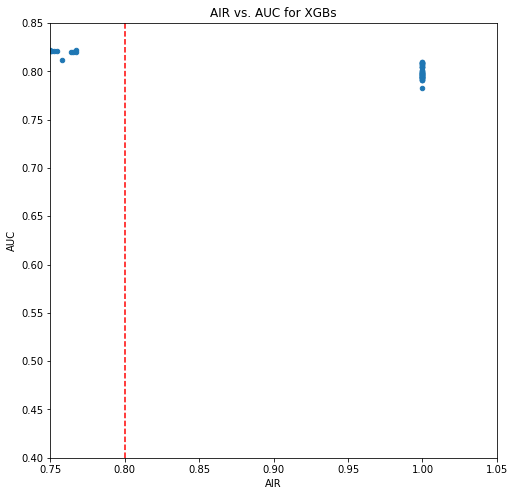

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
_ = mxgb_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for XGBs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

##### Retrain most accurate model above 0.8 AIR

In [29]:
# extract new params dict from ebm_grid_frame
rem_params = mxgb_grid_frame.loc[mxgb_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['seed'] = int(rem_params['seed'])
rem_params['nthread'] = int(rem_params['nthread'])

# retrain

dtrain = xgb.DMatrix(train[rem_x_names], train[y_name])
dvalid = xgb.DMatrix(valid[rem_x_names], valid[y_name])
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
ntree=1000
early_stopping_rounds=100
rem_mxgb= xgb.train(rem_params,
                    dtrain,
                    ntree,
                    early_stopping_rounds=early_stopping_rounds,
                    evals=watchlist)   
        

    

print('Remediated XGB retrained with AUC: %.4f.' % rem_mxgb.best_score)

Best AUC: 0.8100 above 0.8 AIR (1.0000).
[0]	train-auc:0.63716	eval-auc:0.64160
[1]	train-auc:0.63733	eval-auc:0.64191
[2]	train-auc:0.76864	eval-auc:0.76897
[3]	train-auc:0.76996	eval-auc:0.77085
[4]	train-auc:0.78070	eval-auc:0.77963
[5]	train-auc:0.77899	eval-auc:0.77737
[6]	train-auc:0.77310	eval-auc:0.77250
[7]	train-auc:0.77219	eval-auc:0.77174
[8]	train-auc:0.76455	eval-auc:0.76304
[9]	train-auc:0.76518	eval-auc:0.76387
[10]	train-auc:0.76545	eval-auc:0.76363
[11]	train-auc:0.78312	eval-auc:0.78103
[12]	train-auc:0.79068	eval-auc:0.78958
[13]	train-auc:0.79128	eval-auc:0.79060
[14]	train-auc:0.79123	eval-auc:0.79049
[15]	train-auc:0.79138	eval-auc:0.79084
[16]	train-auc:0.79130	eval-auc:0.79069
[17]	train-auc:0.79182	eval-auc:0.79084
[18]	train-auc:0.79154	eval-auc:0.79064
[19]	train-auc:0.79220	eval-auc:0.79133
[20]	train-auc:0.79600	eval-auc:0.79519
[21]	train-auc:0.79584	eval-auc:0.79497
[22]	train-auc:0.79577	eval-auc:0.79458
[23]	train-auc:0.79472	eval-auc:0.79339
[24]	trai

[202]	train-auc:0.80194	eval-auc:0.80093
[203]	train-auc:0.80212	eval-auc:0.80113
[204]	train-auc:0.80226	eval-auc:0.80125
[205]	train-auc:0.80223	eval-auc:0.80117
[206]	train-auc:0.80247	eval-auc:0.80153
[207]	train-auc:0.80243	eval-auc:0.80145
[208]	train-auc:0.80237	eval-auc:0.80132
[209]	train-auc:0.80215	eval-auc:0.80110
[210]	train-auc:0.80202	eval-auc:0.80086
[211]	train-auc:0.80212	eval-auc:0.80094
[212]	train-auc:0.80164	eval-auc:0.80045
[213]	train-auc:0.80122	eval-auc:0.79988
[214]	train-auc:0.80099	eval-auc:0.79963
[215]	train-auc:0.80053	eval-auc:0.79918
[216]	train-auc:0.80049	eval-auc:0.79911
[217]	train-auc:0.79999	eval-auc:0.79859
[218]	train-auc:0.79959	eval-auc:0.79806
[219]	train-auc:0.79937	eval-auc:0.79776
[220]	train-auc:0.79929	eval-auc:0.79761
[221]	train-auc:0.79901	eval-auc:0.79740
[222]	train-auc:0.79900	eval-auc:0.79740
[223]	train-auc:0.79873	eval-auc:0.79715
[224]	train-auc:0.79922	eval-auc:0.79773
[225]	train-auc:0.79922	eval-auc:0.79773
[226]	train-auc:

#### Check that other groups are not adversely impacted by change

In [30]:
# create a frame with remediated XGB predictions

best_mxgb_phat2 = pd.DataFrame(rem_mxgb.predict(dvalid, iteration_range=(0, rem_mxgb.best_ntree_limit)), columns=['phat']) 
best_mxgb_phat2 = pd.concat([valid.reset_index(drop=True), best_mxgb_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_mxgb_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.000
Adverse impact ratio for Black people vs. White people: 1.000
Adverse impact ratio for Females vs. Males: 1.000


#### Print best model parameters for later use

In [25]:
rem_params

{'colsample_bytree': 0.3,
 'colsample_bylevel': 0.9,
 'eta': 0.005,
 'max_depth': 7,
 'reg_alpha': 0.05,
 'reg_lambda': 0.0005,
 'subsample': 0.7,
 'min_child_weight': 10,
 'gamma': 0.4,
 'booster': 'gbtree',
 'eval_metric': 'auc',
 'monotone_constraints': (1,),
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 12345}

#### Print best model features for later use

In [26]:
rem_x_names

['no_intro_rate_period_std',
 'debt_to_income_ratio_missing',
 'loan_to_value_ratio_std',
 'intro_rate_period_std',
 'conforming',
 'debt_to_income_ratio_std',
 'income_std',
 'loan_amount_std',
 'term_360']

##### End timer

In [27]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 16427.14 s.
